In [7]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from tqdm import tqdm
import os
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import sys 
import matplotlib.pyplot as plt

In [3]:
os.chdir('ProtGPT-2')

In [4]:
# Step 1: Dataset class to generate input tensors from the processed sequences 

class AntibodyDataset(Dataset):
    def __init__(self, sequences, tokenizer, max_length=512):
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.sequences[idx],
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "labels": encoded["input_ids"].squeeze(),
        }

In [5]:
# Step 2: Load Tokenizer and from the model
model_name = "nferruz/ProtGPT2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
# Add a padding token if not already present
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [7]:
# Save the updated tokenizer
#tokenizer.save_pretrained('./updated_tokenizer')

In [8]:
# Load the model configuration and update the vocab size for the special tokens
# model is initialized with random weights

config = AutoConfig.from_pretrained(model_name)
config.vocab_size = len(tokenizer)  # Update vocab size for special tokens
model = AutoModelForCausalLM.from_config(config)
model.resize_token_embeddings(len(tokenizer))

Embedding(50258, 1280)

In [9]:
# Load training sequences
sequences_train = pd.read_csv('../data/processed/Prot_input_seq_train_data.csv', header=None)
sequences_train.columns = ['sequences']
sequences_train = sequences_train['sequences'].tolist()

# Load validation sequences
sequences_valid = pd.read_csv('../data/processed/Prot_input_seq_val_data.csv', header=None)
sequences_valid.columns = ['sequences']
sequences_valid = sequences_valid['sequences'].tolist()

In [10]:
# Create Dataset and DataLoader
dataset_train = AntibodyDataset(sequences_train, tokenizer)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

dataset_valid = AntibodyDataset(sequences_valid, tokenizer)
dataloader_valid = DataLoader(dataset_valid, batch_size=16, shuffle=True)

In [11]:
# Step 4: Set Up Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5) # AdamW optimizer
num_epochs = 2 # Number of epochs to train model

In [13]:
# Step 5: Initialize TensorBoard writer
writer = SummaryWriter(log_dir="logs")

In [14]:
# Create models directory to save the trained model, updated tokenizer and checkpoints in 'checkpoints' directory
os.makedirs("./models/checkpoints", exist_ok=True)

In [15]:
# Model evaluation function

def validate(model, val_dataloader, device, writer, epoch, step):
    model.eval()  
    val_loss = 0

    with torch.no_grad():  
        for step_val, batch in enumerate(tqdm(val_dataloader, desc="Validation Progress", file=sys.stdout.flush())):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            
            # Log step loss to TensorBoard
            writer.add_scalar('Validation Loss/Step', loss.item(), epoch * len(val_dataloader) + step_val)

    avg_val_loss = val_loss / len(val_dataloader)
    writer.add_scalar('Validation Loss/epoch', avg_val_loss, epoch * len(val_dataloader) + step)


    print(f"Validation Loss: {avg_val_loss}")

In [16]:
# Training loop for the model 

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for step, batch in enumerate(tqdm(dataloader_train)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Log step loss to TensorBoard
        writer.add_scalar('Training Loss/Step', loss.item(), epoch * len(dataloader_train) + step)
        #print(f"Step Loss: {loss.item()}")

        # Save checkpoint every 500 steps
        if (step + 1) % 500 == 0:
            checkpoint_dir = f"./models/checkpoints/checkpoint_epoch_{epoch+1}_step_{step+1}"
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
            torch.save({
                'epoch': epoch + 1,
                'step': step + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }, checkpoint_path)
            print(f"Checkpoint saved at: {checkpoint_path}")


        # Validate after every 500 steps
        if (step + 1) % 500 == 0:
            print(f"Running validation at step {step + 1}...")
            validate(model, dataloader_valid, device, writer, epoch, step)


    # Log average epoch loss to TensorBoard
    avg_epoch_loss = epoch_loss / len(dataloader_train)
    writer.add_scalar('Training Loss/Epoch', avg_epoch_loss, epoch)

    print(f"Epoch {epoch + 1} Training Loss: {avg_epoch_loss}")


# Create models directory to save the trained model and updated tokenizer
os.makedirs("./models/protgpt2_antibody_model", exist_ok=True)

# Step 7: Save the Trained Model and Tokenizer
model.save_pretrained("./models//protgpt2_antibody_model")
tokenizer.save_pretrained("./models/protgpt2_antibody_model")

# Step 8: Close the TensorBoard writer
writer.close()

Epoch 1/2


 46%|████▋     | 499/1075 [09:17<10:41,  1.11s/it]

Checkpoint saved at: ./models/checkpoints/checkpoint_epoch_1_step_500/checkpoint.pth
Running validation at step 500...


 47%|████▋     | 500/1075 [10:10<2:39:31, 16.65s/it]

Validation Loss: 0.5811623215675354


 93%|█████████▎| 999/1075 [19:15<01:22,  1.09s/it]  

Checkpoint saved at: ./models/checkpoints/checkpoint_epoch_1_step_1000/checkpoint.pth
Running validation at step 1000...


 93%|█████████▎| 1000/1075 [20:07<20:37, 16.50s/it]

Validation Loss: 0.14529657264550527


100%|██████████| 1075/1075 [21:29<00:00,  1.20s/it]


Epoch 1 Training Loss: 0.5721751197063646
Epoch 2/2


 46%|████▋     | 499/1075 [09:04<10:28,  1.09s/it]

Checkpoint saved at: ./models/checkpoints/checkpoint_epoch_2_step_500/checkpoint.pth
Running validation at step 500...


 47%|████▋     | 500/1075 [10:04<2:58:03, 18.58s/it]

Validation Loss: 0.13168553256740173


 93%|█████████▎| 999/1075 [19:08<01:22,  1.09s/it]  

Checkpoint saved at: ./models/checkpoints/checkpoint_epoch_2_step_1000/checkpoint.pth
Running validation at step 1000...


 93%|█████████▎| 1000/1075 [20:01<20:32, 16.43s/it]

Validation Loss: 0.13612292166799306


100%|██████████| 1075/1075 [21:22<00:00,  1.19s/it]


Epoch 2 Training Loss: 0.13747887546239898


### Plot training and validation loss

In [23]:
training_loss_data = pd.read_csv('./data/Training_loss.csv')

In [24]:
val_data_x =[500, 1000, 1500, 2000]
val_data_y = [0.58116, 0.14530, 0.13612, 0.13745]

In [25]:
training_loss_data

,Wall time,Step,Value
0,1.735223e+09,3,4.332076
1,1.735223e+09,4,2.063510
2,1.735223e+09,10,2.230232
3,1.735223e+09,14,1.859230
4,1.735224e+09,15,1.749781
...,...,...,...
995,1.735226e+09,2136,0.146742
996,1.735226e+09,2138,0.154183
997,1.735226e+09,2139,0.143844
998,1.735226e+09,2143,0.134321


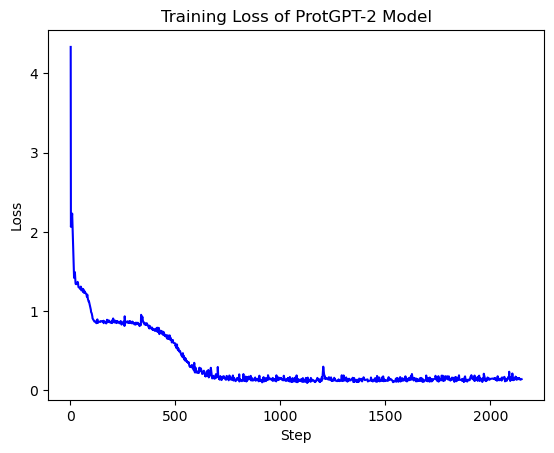

In [26]:
plt.plot(training_loss_data['Step'], training_loss_data['Value'], color='blue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss of ProtGPT-2 Model')
plt.savefig('./data/Training_loss.png', dpi=300)
plt.show()

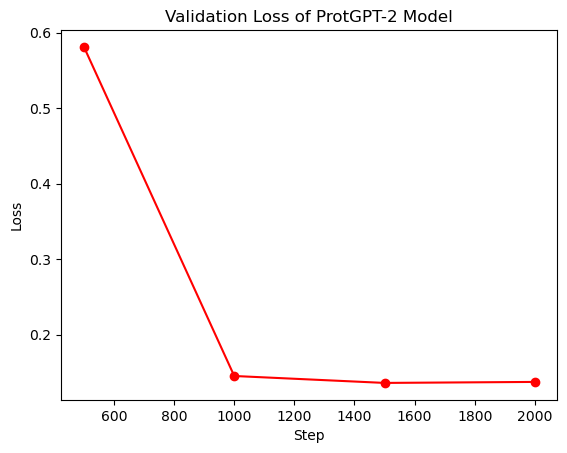

In [27]:
# Model is evaluated on every 500 steps

plt.plot(val_data_x, val_data_y, marker='o', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation Loss of ProtGPT-2 Model')
plt.savefig('./data/Validation_loss.png', dpi=300)
plt.show()